In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imageio

In [18]:
feature_extractor = "sift"
feature_matching = "knn"

In [2]:
image1 = cv2.imread("institute1.jpg")
image1_gray = cv2.cvtColor(image1,cv2.COLOR_BGR2GRAY)
image2 = cv2.imread("institute2.jpg")
image2_gray = cv2.cvtColor(image2,cv2.COLOR_BGR2GRAY)

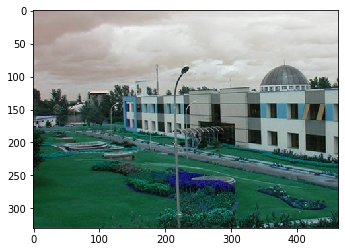

In [9]:
plt.imshow(image1)

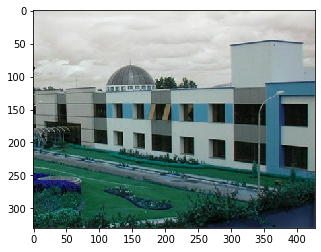

In [10]:
plt.imshow(image2)

In [11]:
def detectAndDescribe(image, method):
    if method == "sift":
        descriptor = cv2.xfeatures2d.SIFT_create()
    elif method == "surf":
        descriptor = cv2.xfeatures2d.SURF_create()
    
    (kps, features) = descriptor.detectAndCompute(image,None)
    return (kps, features)

In [12]:
kpsA, featuresA = detectAndDescribe(image1_gray, method=feature_extractor)
kpsB, featuresB = detectAndDescribe(image2_gray, method=feature_extractor)

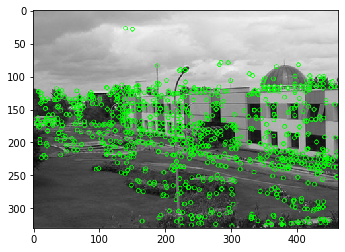

In [13]:
plt.imshow(cv2.drawKeypoints(image1_gray,kpsA,None,color=(0,255,0)))

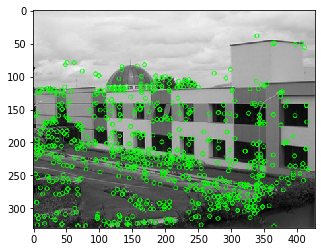

In [14]:
plt.imshow(cv2.drawKeypoints(image2_gray,kpsB,None,color=(0,255,0)))